In [23]:
# librerias
%matplotlib notebook 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("nbagg")
from matplotlib.gridspec import GridSpec

In [24]:
def d(comp,inpu,dire):
    if(comp=='x'): idim = 0
    elif(comp=='z'): idim = 1
    
    if(dire == '+'):
        return (np.roll(inpu, -1, axis = idim)-inpu)/dx
    elif(dire == '-'):
        return (inpu - np.roll(inpu, 1, axis = idim))/dx

In [49]:
#Parametros de entrada
Lz = 110. # en metros (es 110 m porque son tres capas la primera y tercera de 50 m y la segunda de 10 m)
Lx = 110  # en metros, por ahora coloquemos el medio como cuadrado
dx = 1.0  # por ahora coloquen este dx
dz = dx
isx  = 5 # source location in grid in x-direction
isz  = 50 # source location in grid in z-direction
Nx = int(Lx/dx)
Nz = int(Lz/dz)
print(Nx,Nz)
dt   = 0.0001     # time step
T = 0.05  # Tiempo total
time = np.arange(0, T,dt) # Con esta funcio menciona mejor
nt   = len(time)          # maximum number of time steps
print(nt*dt)



110 110
0.05


In [45]:
# Velocity Model

# 1 capa y 3 capa mismas propiedades, con espesor de 50 metros
Densidad = 2400.00
Vp = 3048.00
Vs = 1244.34
Epsil = 0.081
Delt = 0.057

# 2 capa con espesor de 10 metros
Densidad_2= 2140
Vp_2 = 2438.4
Vs_2 = 1625.6
Epsil_2 = 0.065
Delt_2= 0.059

# creacion de capa total
rho = np.ones((Nx, Nz))
C_33 = np.ones((Nx, Nz))
C_44 = np.ones((Nx,Nz))
C_11 = np.ones ((Nx, Nz))
C_13 = np.ones ((Nx,Nz))

# Matriz para 1 capa

rho[:50, :] = Densidad
C_33[:50, :] = ((Vp**2)* Densidad)
C_44[:50, :] = ((Vs**2)* Densidad)
C_11[:50, :] = 2*Epsil*C_33[:50, :]+ C_33[:50, :]
C_13[:50, :] = np.sqrt(2*C_33[:50, :]*(C_33[:50, :]-C_44[:50, :])*Delt + (C_33[:50, :]-C_44[:50, :])**2) - C_44[:50, :]

# Matriz para 2 capa
rho[50:60 , :] = Densidad_2
C_33[50:60, :] = ((Vp_2**2)* Densidad_2)
C_44[50:60, :] = ((Vs_2**2)* Densidad_2)
C_11[50:60, :] = 2*Epsil_2*C_33[50:60, :]+ C_33[50:60, :]
C_13[50:60, :] = np.sqrt(2*C_33[50:60, :]*(C_33[50:60, :]-C_44[50:60, :])*Delt_2 + (C_33[50:60, :]-C_44[50:60, :])**2) - C_44[50:60, :]

# matriz para 3 capa
rho[60:110, :] = Densidad
C_33[60:110, :] = ((Vp**2)* Densidad)
C_44[60:110, :] = ((Vs**2)* Densidad)
C_11[60:110, :] = 2*Epsil*C_33[60:110, :]+ C_33[60:110, :]
C_13[60:110, :] = np.sqrt(2*C_33[60:110, :]*(C_33[60:110, :]-C_44[60:110, :])*Delt + (C_33[60:110, :]-C_44[60:110, :])**2) - C_44[60:110, :]








<IPython.core.display.Javascript object>


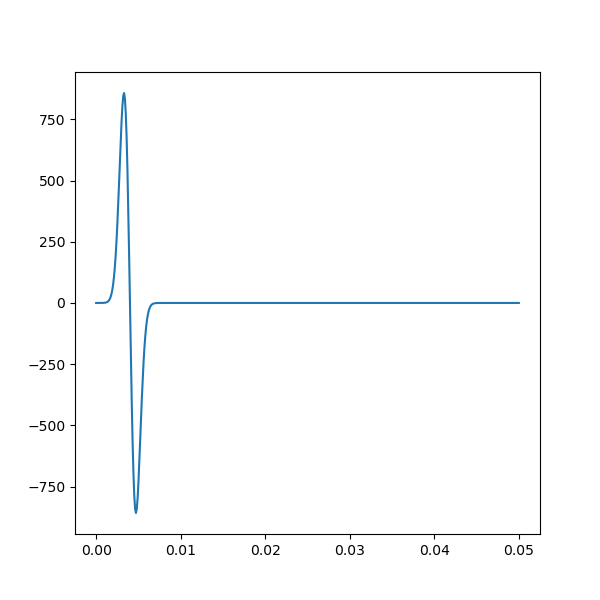

In [50]:
#parametros de la fuente
f0   = 1000. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift
src  = np.zeros(nt)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

plt.ion()
fig2 = plt.figure(figsize=(6, 6))
plt.plot(time,src)
#plt.xlim(0, 1)
plt.show()



In [51]:
# Velocidades y derivadas en cada iteración, necesarias para los ciclos

#velocidad en x
vx    = np.zeros((Nx,Nz)) # vx at time n (now)
dsxx_x = np.zeros((Nx,Nz)) # 1st space derivative of sxx in x-direction
dsxz_z = np.zeros((Nx,Nz)) # 1st space derivative of sxz in z-direction

#velocidad en z
vz    = np.zeros((Nx,Nz)) # vz at time n (now)
dsxz_x = np.zeros((Nx,Nz)) # 1st space derivative of sxz in x-direction
dszz_z = np.zeros((Nx,Nz)) # 1st space derivative of szz in z-direction

# Esfuerzo sigma xx 
sxx = np.zeros ((Nx, Nz))
dvx_x = np.zeros ((Nx, Nz))
dvz_z = np.zeros ((Nx, Nz))

# Esfuerzo sigma zz
szz = np.zeros ((Nx, Nz))

# Esfuerzo sigma xz

sxz = np.zeros ((Nx, Nz))
dvx_z=np.zeros ((Nx, Nz))
dvz_x = np.zeros ((Nx, Nz))

# recptores 
seismo_vx= np.zeros((Nx, nt))
seismo_vz= np.zeros((Nx, nt))


<IPython.core.display.Javascript object>


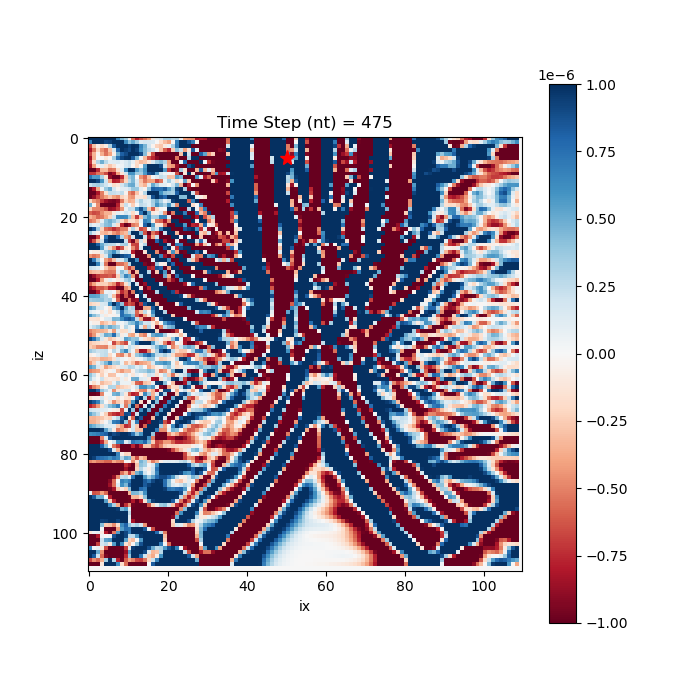

In [52]:
# Plot preparation
#v = max([np.abs(src.min()), np.abs(src.max())])
plt.ion()
fig3 = plt.figure(figsize=(7, 7))
# Initialize animated plot
image = plt.imshow(vz, interpolation='nearest', animated=True,
                   vmin=-1.0e-06, vmax=1.0e-06, cmap=plt.cm.RdBu)

plt.plot(isz, isx, 'r*', markersize=11)
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')
plt.ion()
#plt.show()

In [53]:
# 2D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
# Time extrapolation

for it in range(nt-1):
    # Inject source wavelet (explosion)
    sxx[isx, isz]= sxx[isx, isz] +src[it]
    szz[isx, isz]= szz[isx, isz] +src[it]
        
    # Actualizacion vx     
    # Calculate Space Partial Derivatives       
    for i in range(1, Nx - 1):
        dsxx_x[i, :] = (sxx[i, :] - sxx[i-1, :]) / dx 
    for j in range(1, Nz - 1):
        dsxz_z[:, j] = (sxz[:, j] - sxz[:, j-1]) / dz
        
    # Time Extrapolation    
    vx = vx +(dt/rho) * (dsxx_x + dsxz_z)
    
    # Actualizacion vz
    
    # Calculate Space Partial Derivatives
       
    for i in range(0, Nx - 1):
        dsxz_x[i, :] = (sxz[i + 1, :] - sxz[i, :]) / dx 
    for j in range(0, Nz - 1):
        dszz_z[:, j] = (szz[:, j + 1] - szz[:, j]) / dz
        
    # Time Extrapolation    
    vz = vz +(dt/rho) * (dsxz_x + dszz_z)
   
    
    # Actualizacion sxx
    for i in range(1, Nx - 1):
        dvx_x[i, :] = (vx[i + 1, :] - vx[i, :]) / dx
    for j in range(1, Nz - 1):
        dvz_z[:, j] = (vz[:, j] - vz[:, j-1]) / dz
    # Time Extrapolation 
    sxx = sxx + dt * (C_11*dvx_x + C_13*dvz_z)

    
    # Actualizacion szz
    szz = szz + dt * (C_13*dvx_x + C_33*dvz_z)
    
    # Actualizacion sxz
    for i in range(1, Nx - 1):
        dvz_x[i, :] = (vz[i, :] - vz[i-1, :]) / dx
    for j in range(1, Nz - 1):
        dvx_z[:, j] = (vx[:, j + 1] - vx[:, j]) / dz
        
    # Time Extrapolation     
    sxz = sxz + dt *C_44*(dvz_x + dvx_z)
    
    seismo_vx[0: Nx-1, it-1]= vx[3, 0: Nx-1]
    seismo_vz[0:Nx-1, it-1]= vz[3, 0:Nx-1]

     
    # Plot every time step (nt)
    idisp = 25 # display frequency
    if (it % idisp) == 0:
        plt.title('Time Step (nt) = %d' % it)    
        image.set_data(vz)
        plt.gcf().canvas.draw() 
        
   

<IPython.core.display.Javascript object>


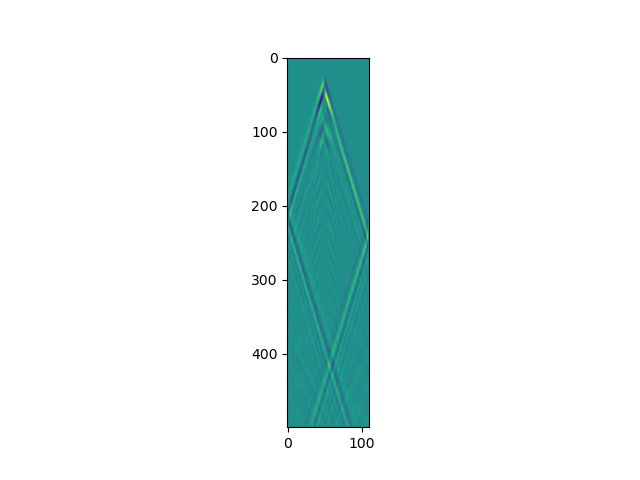

In [54]:
# Initialize animated plot
%matplotlib notebook 

plt.imshow(seismo_vz.transpose())

plt.show()


